In [2]:
# ===============================================================
# PORTBRAIN – DQN Ship Handling with Dynamic Ship Counts
# ===============================================================

import random
from collections import deque, namedtuple

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from tqdm import trange
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# Reproducibility & Device
# ---------------------------------------------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [3]:
# ---------------------------------------------------------------
# Hyperparameters
# ---------------------------------------------------------------
NUM_EPISODES        = 100
MAX_STEPS_PER_EP    = 50

GAMMA               = 0.99
LR                  = 1e-3
BATCH_SIZE          = 64
REPLAY_CAPACITY     = 10_000

EPS_START           = 1.0
EPS_END             = 0.1
EPS_DECAY_EPISODES  = 80

TARGET_UPDATE_FREQ  = 10
MAX_SHIPS_QUEUE     = 20
MAX_HANDLE_PER_STEP = 3

TRAINING_HISTORY_CSV = "portbrain_training_history.csv"

# Print only 10 selected episodes
EPISODES_TO_PRINT = {1, 5, 10, 20, 25, 40, 50, 75, 90, 100}


In [4]:
# ---------------------------------------------------------------
# Environment with RANDOM initial ships + arrivals
# ---------------------------------------------------------------
class PortEnv:
    def __init__(self,
                 max_ships_queue=MAX_SHIPS_QUEUE,
                 max_handle_per_step=MAX_HANDLE_PER_STEP,
                 max_steps=MAX_STEPS_PER_EP,
                 arrival_rate=1.0):
        
        self.max_ships_queue = max_ships_queue
        self.max_handle_per_step = max_handle_per_step
        self.max_steps = max_steps
        self.arrival_rate = arrival_rate

        self.state_dim = 3
        self.action_dim = max_handle_per_step + 1

        self.reset()

    def reset(self):
        self.ships_waiting = np.random.randint(5, 13)
        self.initial_ships = self.ships_waiting

        self.ships_handled = 0
        self.timestep = 0
        self.done = False

        return self._get_obs()

    def _get_obs(self):
        return np.array([self.ships_waiting,
                         self.ships_handled,
                         self.timestep], dtype=np.float32)

    def step(self, action):
        if self.done:
            raise ValueError("Episode finished. Call reset().")

        self.timestep += 1
        action = max(0, min(int(action), self.max_handle_per_step))

        handled = min(action, self.ships_waiting)
        self.ships_waiting -= handled
        self.ships_handled += handled

        new_arrivals = np.random.poisson(self.arrival_rate)
        self.ships_waiting = min(self.ships_waiting + new_arrivals,
                                 self.max_ships_queue)

        reward = handled * 2.0
        reward -= 1.0 * self.ships_waiting
        reward -= 0.1

        if (self.ships_waiting == 0 and self.timestep > 0) or \
           (self.timestep >= self.max_steps):
            self.done = True

        return self._get_obs(), reward, self.done, {
            "ships_waiting": self.ships_waiting,
            "ships_handled": self.ships_handled,
            "timestep": self.timestep,
            "new_arrivals": new_arrivals,
            "handled_this_step": handled,
        }


In [5]:
# ---------------------------------------------------------------
# Replay Memory
# ---------------------------------------------------------------
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [6]:
# ---------------------------------------------------------------
# DQN Network
# ---------------------------------------------------------------
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )

    def forward(self, x):
        return self.layers(x)


In [7]:
# ---------------------------------------------------------------
# DQN Agent
# ---------------------------------------------------------------
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.state_dim = state_dim
        self.action_dim = action_dim

        self.gamma = GAMMA
        self.batch_size = BATCH_SIZE

        self.policy_net = DQN(state_dim, action_dim).to(device)
        self.target_net = DQN(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = ReplayMemory(REPLAY_CAPACITY)

    def get_epsilon(self, episode):
        frac = min(1.0, episode / EPS_DECAY_EPISODES)
        return EPS_START + frac * (EPS_END - EPS_START)

    def select_action(self, state, episode):
        eps = self.get_epsilon(episode)
        if random.random() < eps:
            return random.randrange(self.action_dim)

        state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_vals = self.policy_net(state_t)
        return int(torch.argmax(q_vals).item())

    def optimize(self):
        if len(self.memory) < self.batch_size:
            return None

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        state_b = torch.tensor(batch.state, dtype=torch.float32, device=device)
        action_b = torch.tensor(batch.action, dtype=torch.int64,
                                device=device).unsqueeze(1)
        reward_b = torch.tensor(batch.reward, dtype=torch.float32,
                                device=device).unsqueeze(1)
        next_state_b = torch.tensor(batch.next_state, dtype=torch.float32,
                                    device=device)
        done_b = torch.tensor(batch.done, dtype=torch.float32,
                              device=device).unsqueeze(1)

        q_values = self.policy_net(state_b).gather(1, action_b)

        with torch.no_grad():
            next_q = self.target_net(next_state_b).max(1, keepdim=True)[0]

        target = reward_b + self.gamma * next_q * (1 - done_b)

        loss = nn.SmoothL1Loss()(q_values, target)

        self.optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        self.optimizer.step()

    def update_target(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


In [8]:
# ---------------------------------------------------------------
# Pretty Episode Summary Printer
# ---------------------------------------------------------------
def print_episode_summary(ep, metrics):
    print("\n" + "─" * 70)
    print(f"📘 Episode {ep}")
    print(f" • Initial Ships      : {metrics['initial_ships']}")
    print(f" • Total Arrivals     : {metrics['total_arrivals']}")
    print(f" • Ships Handled      : {metrics['ships_handled']}")
    print(f" • Ships Remaining    : {metrics['ships_remaining']}")
    print(f" • Reward             : {metrics['total_reward']:.2f}")
    print(f" • Steps              : {metrics['steps']}")
    print(f" • Avg Q-value        : {metrics['avg_q']:.2f}")
    print(f" • Epsilon            : {metrics['epsilon']:.3f}")

In [9]:
# ---------------------------------------------------------------
# Initialize Environment & Agent
# ---------------------------------------------------------------
env = PortEnv()
agent = DQNAgent(env.state_dim, env.action_dim)

episode_history = []

In [10]:
# ---------------------------------------------------------------
# Training Loop
# ---------------------------------------------------------------
print("Starting training...\n")

for ep in trange(NUM_EPISODES, desc="Training"):
    state = env.reset()
    done = False

    total_reward = 0.0
    q_values_list = []
    steps = 0

    eps = agent.get_epsilon(ep)

    initial_ships = env.initial_ships
    total_arrivals = 0
    total_wait_time = 0.0
    last_info = None

    while not done and steps < MAX_STEPS_PER_EP:
        steps += 1

        action = agent.select_action(state, ep)

        with torch.no_grad():
            q_vals = agent.policy_net(torch.tensor(state, dtype=torch.float32,
                                                   device=device).unsqueeze(0))
            q_values_list.append(q_vals.max().item())

        next_state, reward, done, info = env.step(action)

        last_info = info
        total_reward += reward
        total_arrivals += info["new_arrivals"]
        total_wait_time += info["ships_waiting"]

        agent.memory.push(state, action, reward, next_state, float(done))
        agent.optimize()

        state = next_state

    if (ep + 1) % TARGET_UPDATE_FREQ == 0:
        agent.update_target()

    avg_q = float(np.mean(q_values_list))

    metrics = {
        "initial_ships": initial_ships,
        "total_arrivals": total_arrivals,
        "ships_handled": last_info["ships_handled"],
        "ships_remaining": last_info["ships_waiting"],
        "total_reward": total_reward,
        "steps": steps,
        "avg_q": avg_q,
        "epsilon": eps,
    }

    # Print only selected episodes
    if (ep + 1) in EPISODES_TO_PRINT:
        print_episode_summary(ep + 1, metrics)

    episode_history.append({
        "episode": ep + 1,
        **metrics
    })

print("\nTraining completed!")

Starting training...



Training:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\shaar\AppData\Local\Temp\ipykernel_31612\1486749210.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:256.)
  state_b = torch.tensor(batch.state, dtype=torch.float32, device=device)
Training:   6%|▌         | 6/100 [00:00<00:01, 52.65it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 1
 • Initial Ships      : 8
 • Total Arrivals     : 13
 • Ships Handled      : 21
 • Ships Remaining    : 0
 • Reward             : -118.90
 • Steps              : 19
 • Avg Q-value        : 1.00
 • Epsilon            : 1.000

──────────────────────────────────────────────────────────────────────
📘 Episode 5
 • Initial Ships      : 7
 • Total Arrivals     : 1
 • Ships Handled      : 8
 • Ships Remaining    : 0
 • Reward             : -3.50
 • Steps              : 5
 • Avg Q-value        : 0.81
 • Epsilon            : 0.955

──────────────────────────────────────────────────────────────────────
📘 Episode 10
 • Initial Ships      : 11
 • Total Arrivals     : 21
 • Ships Handled      : 32
 • Ships Remaining    : 0
 • Reward             : -56.50
 • Steps              : 15
 • Avg Q-value        : 3.36
 • Epsilon            : 0.899


Training:  22%|██▏       | 22/100 [00:00<00:01, 40.15it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 20
 • Initial Ships      : 10
 • Total Arrivals     : 22
 • Ships Handled      : 32
 • Ships Remaining    : 0
 • Reward             : -111.20
 • Steps              : 22
 • Avg Q-value        : 3.23
 • Epsilon            : 0.786

──────────────────────────────────────────────────────────────────────
📘 Episode 25
 • Initial Ships      : 11
 • Total Arrivals     : 19
 • Ships Handled      : 30
 • Ships Remaining    : 0
 • Reward             : -19.00
 • Steps              : 20
 • Avg Q-value        : 4.50
 • Epsilon            : 0.730


Training:  48%|████▊     | 48/100 [00:01<00:00, 53.51it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 40
 • Initial Ships      : 11
 • Total Arrivals     : 12
 • Ships Handled      : 23
 • Ships Remaining    : 0
 • Reward             : -14.10
 • Steps              : 11
 • Avg Q-value        : 4.33
 • Epsilon            : 0.561

──────────────────────────────────────────────────────────────────────
📘 Episode 50
 • Initial Ships      : 8
 • Total Arrivals     : 23
 • Ships Handled      : 31
 • Ships Remaining    : 0
 • Reward             : 13.20
 • Steps              : 18
 • Avg Q-value        : 8.05
 • Epsilon            : 0.449


Training:  89%|████████▉ | 89/100 [00:01<00:00, 77.61it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 75
 • Initial Ships      : 8
 • Total Arrivals     : 4
 • Ships Handled      : 12
 • Ships Remaining    : 0
 • Reward             : 12.50
 • Steps              : 5
 • Avg Q-value        : 12.29
 • Epsilon            : 0.167

──────────────────────────────────────────────────────────────────────
📘 Episode 90
 • Initial Ships      : 7
 • Total Arrivals     : 4
 • Ships Handled      : 11
 • Ships Remaining    : 0
 • Reward             : 10.50
 • Steps              : 5
 • Avg Q-value        : 13.43
 • Epsilon            : 0.100


Training: 100%|██████████| 100/100 [00:01<00:00, 58.61it/s]


──────────────────────────────────────────────────────────────────────
📘 Episode 100
 • Initial Ships      : 6
 • Total Arrivals     : 4
 • Ships Handled      : 10
 • Ships Remaining    : 0
 • Reward             : 9.40
 • Steps              : 6
 • Avg Q-value        : 15.03
 • Epsilon            : 0.100

Training completed!


In [11]:
history_df = pd.DataFrame(episode_history)
history_df.head()

,episode,initial_ships,total_arrivals,ships_handled,ships_remaining,total_reward,steps,avg_q,epsilon
0,1,8,13,21,0,-118.9,19,0.997481,1.00000
1,2,8,18,26,0,-35.1,21,0.919193,0.98875
2,3,11,17,28,0,-18.0,20,0.989359,0.97750
3,4,7,8,15,0,-19.9,9,0.868939,0.96625
4,5,7,1,8,0,-3.5,5,0.813617,0.95500


In [12]:
history_df.to_csv(TRAINING_HISTORY_CSV, index=False)
print("Saved training history to:", TRAINING_HISTORY_CSV)


Saved training history to: portbrain_training_history.csv


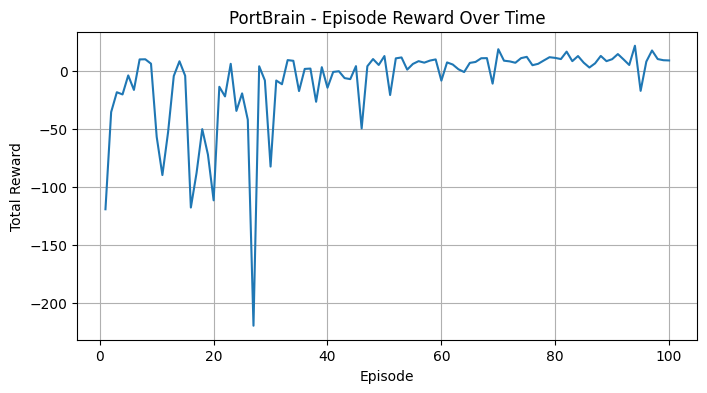

In [13]:
plt.figure(figsize=(8, 4))
plt.plot(history_df["episode"], history_df["total_reward"])
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PortBrain - Episode Reward Over Time")
plt.grid(True)
plt.show()